# Towards fixing urban decay in Detroit by predicting the compliance probability for blight tickets violations

Blight violations are violations of City of Detroit ordinances that govern how property owners must maintain the exterior of their real property. 

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas_summary import DataFrameSummary

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Exploration

Get data

In [2]:
#we assume they datasets live in the current working dir.
train = pd.read_csv('train.csv', encoding='mac_roman')
test = pd.read_csv('test.csv')
addresses = pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')

Let us take a peak at the data

In [3]:
train.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [4]:
train.columns, len(train.columns)

(Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
        'violation_street_number', 'violation_street_name',
        'violation_zip_code', 'mailing_address_str_number',
        'mailing_address_str_name', 'city', 'state', 'zip_code',
        'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
        'violation_code', 'violation_description', 'disposition', 'fine_amount',
        'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
        'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
        'payment_date', 'payment_status', 'collection_status',
        'grafitti_status', 'compliance_detail', 'compliance'],
       dtype='object'), 34)

In [5]:
test.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [6]:
train.columns, len(test.columns)

(Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
        'violation_street_number', 'violation_street_name',
        'violation_zip_code', 'mailing_address_str_number',
        'mailing_address_str_name', 'city', 'state', 'zip_code',
        'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
        'violation_code', 'violation_description', 'disposition', 'fine_amount',
        'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
        'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
        'payment_date', 'payment_status', 'collection_status',
        'grafitti_status', 'compliance_detail', 'compliance'],
       dtype='object'), 27)

In [27]:
addresses.head(3)

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"


In [28]:
latlons.head(3)

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228


Potential data leaking columns

In [7]:
set(test.columns).symmetric_difference(set(train.columns))

{'balance_due',
 'collection_status',
 'compliance',
 'compliance_detail',
 'payment_amount',
 'payment_date',
 'payment_status'}

Merge ticket info with geolocation info

In [10]:
train = train.merge(pd.merge(addresses, latlons, on ='address', how ='inner'), on ='ticket_id', how = 'inner');
test = test.merge(pd.merge(addresses, latlons, on ='address', how ='inner'), on ='ticket_id', how = 'inner');

In [11]:
train.head(1)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268


Here are the cities where the violators were living when the ticket was issued (notice the typos!)

In [12]:

train['city']

0             CHICAGO
1             Detroit
2             DETROIT
3             DETROIT
4             DETROIT
5           LOG BEACH
6             Clinton
7             Detroit
8             Detroit
9             Detroit
10            Detroit
11             Canton
12            Detroit
13            Detroit
14            Detroit
15         Ortonville
16            Detroit
17            Detroit
18            Detroit
19            Detroit
20            Detroit
21            Detroit
22            Detroit
23            Detroit
24            Detroit
25            Detroit
26            DETROIT
27        EAST POINTE
28                Det
29            DETROIT
             ...     
250276        DETROIT
250277        DETROIT
250278        DETROIT
250279        DETROIT
250280        DETROIT
250281        INKSTER
250282        INKSTER
250283     SOUTHFIELD
250284        DETROIT
250285    MARINE CITY
250286    MARINE CITY
250287        DETROIT
250288        DETROIT
250289        DETROIT
250290    

## Data processing

Let us define some useful lists

In [13]:
#Use these two lines of codes to obtain the Detroit_with_typos word set below:
#filtered = list(filter(lambda x: x not in Detroit_with_typos, train['city']))
#set([c for c in filtered if c.startswith('DET')])

Detroit_with_typos = set(
['DETROIT', 'Detroit', 'DETORIT', 'DETROT', 'Detrot', 'detroit', 'detrot',
 'DET', 'DETROI', 'DETROIR', 'DET.', 'DETRIOIT', 'Det', 'D', 'det', 'd',
 'DERTROIT', 'DETRIOT', 'DETRIT', 'Deroit', 'detriot', 'DEROT', 'DETRPOT',
 'Detorit','DETRTOI', 'DET,', 'DETR4OIT', 'DETRIUT', 'DEROIT', 'DEt',
 'Det.', 'DETOIT', 'DERTOIT',  'DEETROIT', 'DETROTI', 'DTEROIT','DETROIOT',
 'DETROIT1','DETROITQ', 'DET ,', 'DET ROIT', 'DET,.', 'DET. MI.', 'DET.,',
 'DET., MI.', 'DETAROIT', 'DETEOIT', 'DETEROIT', 'DETORIIT', 'DETREOIT',
 'DTROIT', 'DETRIOIT', 'DETRJOIT', 'DETROIIT', 'DETROIRT', 'DETROIS',
 'DETROIT  4', 'DETROIT,', 'DETROIT, MI.', 'DETROIT, MI. 48206', 'DETROITF',
 'DETROITI', 'DETROITL', 'DETROITM', 'DETROITT', 'DETROITY','DETROIT`', 
 'DETROITdetroit', 'DETROIYT', 'DETROKT', 'DETROOIT', 'DETROPIT',
 'DETROUIT', 'DETRROIT', 'DETTROIT', 'DETTROITM', 'DETYROIT', 'DETZVILLE',
 'Det', 'Detrioit', 'Detriot', 'Detriut','Detro;it', 'Detrofit', 'Detroi', 
 'Detroir', 'Detroit`', 'Detroitf', 'Detroitli', 'Detroti', 'Detrroit',
 'Dteroit', 'dteroit', 'DEtroit', 'cetroit', 'deroit', 'dertoit', 
 'deteroit', 'detoit', 'detrtoit', 'BELOIT', 'CETROIT', 'DEEEEETROIT',
 'DERROIT', 'DEYROIT', 'DFETROIT', 'DKETROIT', 'DRTROIT', 'DWETROIT',
 'EAST  DETROIT', 'ETROIT','WARRENDETROIT', 'dETROIT','det.', 'det48234',
 'detroiit', 'detroiot', 'detroir', 'detroit,mi', 'detroit`', 'detroitt',
 'detrorit', 'DE',  'DD', 'DDD', 'DDDDDD', 'DDDDDDD', 'DDDDDDDD', 'deT'])

#These columns will be dropped due to potential leakage during preprocessing
data_leakage = set(
['payment_amount', 'payment_date', 'payment_status', 'balance_due',
 'collection_status', 'compliance_detail'])

#These columns will be dropped during preprocessing
drop_these = [
'inspector_name', 'violation_street_number', 'violation_street_name',
'violation_zip_code', 'violator_name', 'violation_description', 'address', 
'ticket_issued_date', 'hearing_date', 'mailing_address_str_number', 
'mailing_address_str_name', 'city', 'state', 'judgment_amount','zip_code',
'non_us_str_code', 'country', 'grafitti_status', 'admin_fee', 'state_fee',
'late_fee', 'discount_amount', 'clean_up_cost', 'agency_name', 'violation_code']
#note: only one person has a non-NAN entry in graffity_status column,
#so we can just drop it

#Relevant categorical, binary and numeric variables that we will use during trainings
cat_vars = ['disposition', 'mailing_non_USA', 'mailing_non_DT', 'mailing_non_MI']
num_vars = ['fine_amount', 'days_from_issue_to_hearing', 'lat', 'lon']

#Elements of set(X_test['disposition']) that will be replaced during preprocessing
replace = ['Responsible - Compl/Adj by Determi', 'Responsible by Dismissal', 
           'Responsible (Fine Waived) by Admis', 'Responsible - Compl/Adj by Default']

Let us define some helper functions to preprocess and efficiently encode/scale the datasets:

In [14]:
def preprocess(train, test):
    '''Create new features and clean the train and test data'''
    for df in [train, test]:        
        #create new features using the mailing address of violator
        df['mailing_non_USA'] = [1 if country not in ['USA'] else 0 for country in df['country']]
        df['mailing_non_DT'] = [1 if city not in Detroit_with_typos else 0 for city in df['city']]
        df['mailing_non_MI'] = [1 if state not in ['MI'] else 0 for state in df['state']]

        #create a new feature: the number of days elaspsed from the ticket-issue-day to the hearing day
        df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'])
        df['hearing_date'] = pd.to_datetime(df['hearing_date'])
        delta = df['hearing_date'] - df['ticket_issued_date']
        df.loc[delta.notnull(), 'days_from_issue_to_hearing'] = delta.dt.days

        #drop potential data leaking fields
        if set(df.columns).intersection(data_leakage):
            df = df.drop(data_leakage, axis = 1)
            
        #drop these irrelevant fields, or fields with mostly NA's in them
        df = df.drop(drop_these, axis = 1)
    
        #cleaning missing data 
        df['days_from_issue_to_hearing'].fillna(np.mean(df['days_from_issue_to_hearing']), inplace = True)
        df['fine_amount'].fillna(np.mean(df['fine_amount']), inplace = True)
        df['lat'].fillna(np.mean(df['lat']), inplace = True)
        df['lon'].fillna(np.mean(df['lon']), inplace = True)

        if set(df.columns).intersection(set(['compliance'])):
            #trim traininig data:
            df = df.dropna(axis=0)
            df.reset_index(inplace=True, drop=True)
            X_train = df.drop('compliance',axis =1)            
            y_train = pd.DataFrame(df['compliance'])
        else: 
            #trim test data:
            #Replace elements of set(X_test['disposition']) that do not appear
            #in set(X_train['disposition']), with 'Responsible by Default'.
            df['disposition'].replace(replace, 'Responsible by Default', inplace=True)
            X_test = df
    return X_train, X_test, y_train

def EncoderScaler(X_train, X_test):
    '''Transform train and test data into machine-friendly form''' 
    
    #onehotencode categorical train data and scale numeric train data
    X1 = pd.get_dummies(X_train[cat_vars])
    scaler = StandardScaler().fit(X_train[num_vars])
    X2 = pd.DataFrame(scaler.transform(X_train[num_vars]), columns = num_vars)
    
    #join the dataframes horizontally
    X_train_map = X1.join(X2)
    
    #replace resulting NA's with means and then reset index
    mean =np.mean(X_train_map['days_from_issue_to_hearing'])
    X_train_map['days_from_issue_to_hearing'].fillna(mean, inplace = True)
    X_train_map['lat'].fillna(np.mean(X_train_map['lat']), inplace = True)
    X_train_map['lon'].fillna(np.mean(X_train_map['lon']), inplace = True)
    X_train_map['fine_amount'].fillna(np.mean(X_train_map['fine_amount']),
     inplace = True)
    X_train_map.reset_index(inplace=True, drop=True)
    
    #do the same for the test set
    X3 = pd.get_dummies(X_test[cat_vars])
    X4 = pd.DataFrame(scaler.transform(X_test[num_vars]), columns = num_vars)
    X_test_map = X3.join(X4)
    return X_train_map, X_test_map

Now use preprocess() to get the cleaned up data with the relevant features

In [15]:
X_train, X_test, y_train = preprocess(train, test)
print(X_train.shape, X_test.shape, y_train.shape)

(159880, 9) (61001, 9) (159880, 1)


In [16]:
X_train.head(2)

,ticket_id,disposition,fine_amount,lat,lon,mailing_non_USA,mailing_non_DT,mailing_non_MI,days_from_issue_to_hearing
0,22056,Responsible by Default,250.0,42.390729,-83.124268,0,1,1,369.0
1,27586,Responsible by Determination,750.0,42.326937,-83.135118,0,0,0,378.0


and then use EncoderScaler() to transform the categorical and numeric data

In [17]:
X_train_map, X_test_map = EncoderScaler(X_train, X_test)

In [18]:
X_train_map.head(4)

,mailing_non_USA,mailing_non_DT,mailing_non_MI,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,fine_amount,days_from_issue_to_hearing,lat,lon
0,0,1,1,0,0,1,0,-0.158417,4.732380,0.026468,-0.136219
1,0,0,0,0,0,0,1,0.581607,4.876101,-1.692087,-0.252247
2,0,1,1,0,0,1,0,-0.158417,3.997806,-6.586552,-1.034100
3,0,1,0,0,0,1,0,0.581607,2.879977,1.177804,0.941420


In [19]:
DataFrameSummary(X_train_map).summary()

,mailing_non_USA,mailing_non_DT,mailing_non_MI,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,fine_amount,days_from_issue_to_hearing,lat,lon
count,159880,159880,159880,159880,159880,159880,159880,159880,159880,159880,159880
mean,6.88016e-05,0.38639,0.101482,0.00121966,0.0856955,0.865274,0.0478109,-3.74175e-14,4.12723e-15,-1.15306e-13,-8.24458e-14
std,0.00829441,0.486923,0.301967,0.0349025,0.279915,0.341432,0.213367,1,1,1,1
min,0,0,0,0,0,0,0,-0.52843,-6.54173,-6.58655,-13.8186
25%,0,0,0,0,0,1,0,-0.23242,-0.66514,-0.679139,-0.794793
50%,0,0,0,0,0,1,0,-0.158417,-0.297853,0.0761994,-0.138884
75%,0,1,0,0,0,1,0,-0.158417,0.436721,0.792405,0.837597
max,1,1,1,1,1,1,1,14.2721,125.522,64.5387,6.40107
counts,159880,159880,159880,159880,159880,159880,159880,159880,159880,159880,159880
uniques,2,2,2,2,2,2,2,40,583,61560,66840


## Modeling

We now define our models to test

In [20]:
#random forrest classifier
rfc = RandomForestClassifier(n_estimators = 100, max_depth =3, n_jobs=-1, random_state=0)

#gradient boost classifier
grd = GradientBoostingClassifier(n_estimators=100, max_depth = 3, min_samples_split=50, 
                                 min_samples_leaf=10, learning_rate=0.05 , random_state=0)

and define functions to evaluate them using a validation set

In [21]:
def train_vs_val_err(X_train, y_train, model):
    '''Returns training and validation AUC scores'''
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0)
    model.fit(np.array(X_tr),np.array(y_tr))

    y_pred_tr = model.predict_proba(np.array(X_tr))
    fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_pred_tr[:,1])
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    y_pred_val = model.predict_proba(np.array(X_val))
    fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_val[:,1])
    roc_auc_val = auc(fpr_val, tpr_val)
    return roc_auc_tr, roc_auc_val

def ROC_curve(X_train, y_train, model):
    '''Calculates AUC score on the validation set and plots the ROC curve'''
    if model == rfc: name = 'Random Forrest'
    else: name = 'Grd. Boost'
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)
    model.fit(X_train,y_train)
    y_pred = model.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_pred[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='{:s} (area = {:0.3f})'.format(name, roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (Detroit blight model)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()

Use train_vs_val_err() to compare train and validation AUC scores to check if rfc is overfitting

In [22]:
train_vs_val_err(X_train_map, y_train, rfc)  #random forrest

(0.78247937965136294, 0.77848097151852957)

In [23]:
train_vs_val_err(X_train_map, y_train, grd) #gradient boosting decision tree

(0.79107084961226148, 0.78715081368968576)

Plot ROC curves:

<IPython.core.display.Javascript object>


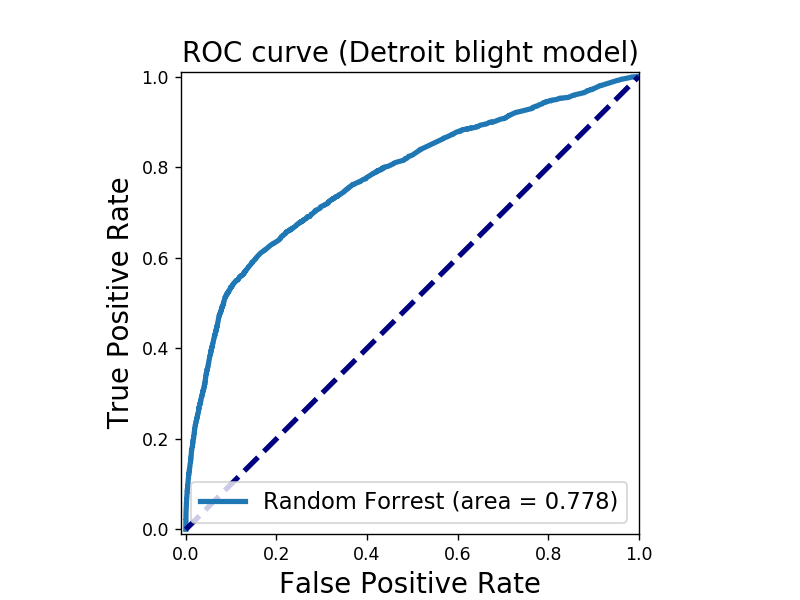

In [24]:
ROC_curve(X_train_map, y_train, rfc) #random forrest

<IPython.core.display.Javascript object>


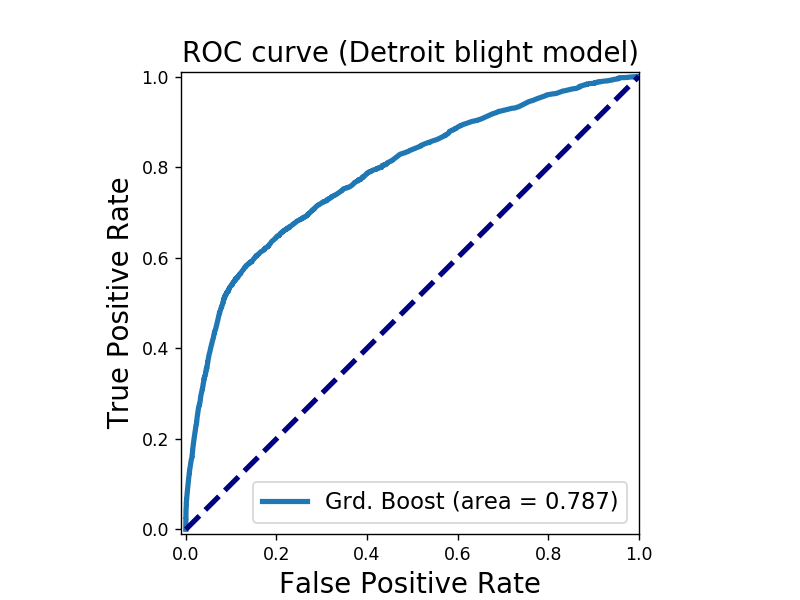

In [25]:
ROC_curve(X_train_map, y_train, grd) #gradient boosting decision tree

## Predictions

Make predictions on the test set. Construct a data series for the 'compliance' probability with 'ticket_id' as index 

In [26]:
model = rfc
model.fit(np.array(X_train_map),np.array(y_train))
y_pred = model.predict_proba(np.array(X_test_map))
y_pred = pd.Series(y_pred[:,1], index =X_test['ticket_id'].tolist(), name='compliance');
y_pred.head()

284932    0.048492
285362    0.040728
285361    0.049621
285338    0.057626
285346    0.057626
Name: compliance, dtype: float64

Upon submission, this model gave a AUC of 0.772 in the leaderboard putting the model in a top 10 position